In [1]:
import scipy as sp
from scipy import sparse
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse.linalg import spsolve

## Define the sparse matrices to solve $Au = Mb$

In [2]:
def A_matrix(n):
    h = 1/n
    Id = sparse.eye(n-1).toarray()
    Aux = -1*(sparse.eye(n-1,n-1,1).toarray() + sparse.eye(n-1,n-1,-1).toarray()) 
    T = 8*Id + Aux
    S = Id - Aux
    A = 3/h*((sparse.kron(Id,T).toarray()) + sparse.kron(Aux,S).toarray()) 
    return sparse.csr_matrix(A)

In [3]:
def M_matrix(n):
    h = 1/n
    Id = sparse.eye(n-1).toarray()
    Aux = (sparse.eye(n-1,n-1,1).toarray() + sparse.eye(n-1,n-1,-1).toarray())
    Q = (1/4)*(4*Id + Aux)
    M = h*(sparse.kron(Id,4*Q).toarray() + sparse.kron(Aux,Q).toarray())
    return sparse.csr_matrix(M)

## Define the vector $u$ 

In [4]:
def b_vector(n):
    x=np.linspace(0,1,n+1)   #We have n-1 inner points
    y=np.linspace(0,1,n+1)   
    x = x[1:n]               #We just want inner points of the grid
    y = y[1:n]
    xx, yy = np.meshgrid(x,y,sparse=True)
    b = 5*np.pi**2*np.sin(2*np.pi*xx)*np.sin(np.pi*yy) #f(i,j)
    b = b.flatten()
    return b

In [5]:
#Solve the system Ax = v
def solve_system(A,v,n): #v = M.dot(b)
    u = spsolve(A, v).reshape(n-1,n-1)
    return u
    

## Plot the solution to the system of linear equations

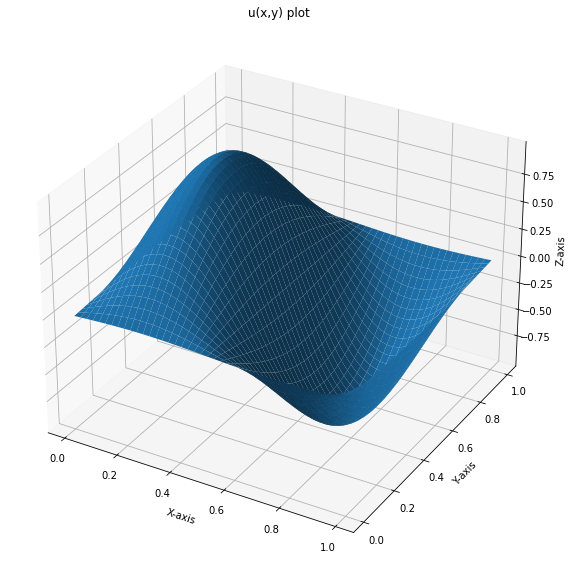

In [7]:
n = 128
A = A_matrix(n)
M = M_matrix(n)
b = b_vector(n)
v = M.dot(b)
u = solve_system(A,v,n)

x = np.linspace(0,1,n+1)   #We have n-1 inner points
y = np.linspace(0,1,n+1)   
x = x[1:n]               #We just want inner points of the grid
y = y[1:n]
xx, yy = np.meshgrid(x,y,sparse=True)


fig = plt.figure(figsize=(10,10), edgecolor='red')
ax = fig.add_subplot(111, projection='3d')
z = u.reshape(xx.size,yy.size) 
ax.plot_surface(xx,yy,z)

# Set boundary values
#ax.axhline(0, color='red', linestyle='--', linewidth=5)  # Horizontal line at y=0
#ax.axvline(0, color='red', linestyle='--', linewidth=5)  # Vertical line at x=0
ax.axhline(5, color='red', linestyle='--', linewidth=1)    # Example horizontal boundary line
ax.axvline(-3, color='blue', linestyle='--', linewidth=1)  # Example vertical boundary line

# Set axis labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('u(x,y) plot')

# Add colorbar
#fig.colorbar(xx,yy, ax=ax, shrink=0.5, aspect=10)
               
plt.show()

# Build functions to evaluate the functions $u$ and $\nabla{u}$

In [8]:
def hat(n,k,x): #n = dimension, k = node, x = input
    
    if ((k-1 < n*x) & (n*x <= k)):
        return 1-k+n*x
    elif ((k < n*x) & (n*x < k+1)):
        return 1+k-n*x
    else:
        return 0

In [9]:
def der_hat(n,k,x):
    if ((k-1 < n*x) & (n*x <= k)):
        return n
    elif ((k < n*x) & (n*x < k+1)):
        return -n
    else:
        return 0
    

In [10]:
def phi(n,i,j,x,y):
    return hat(n,i,x)*hat(n,j,y)

In [11]:
def psi_x(n,i,j,x,y):
    return der_hat(n,i,x)*hat(n,j,y)

In [12]:
def psi_y(n,i,j,x,y):
    return hat(n,i,x)*der_hat(n,j,y)

In [13]:
def add_boundary_values(u,n):
    A = np.zeros((n+1, n+1))
    r, c = 1, 1
    A[r:r+u.shape[0], c:c+u.shape[1]] = u
    return A

In [14]:
def u_eval(u,n,x,y): #u is the matrix with boundary values
    
    k = int(np.floor(n*x))
    l = int(np.floor(n*y))
    #l = int(np.floor(n*x))
    #k = int(np.floor(n*y))
    
    return u[l][k]*phi(n,k,l,x,y) + u[l+1][k]*phi(n,k+1,l,x,y) + u[l][k+1]*phi(n,k,l+1,x,y) + u[l+1][k+1]*phi(n,k+1,l+1,x,y)


#Example code:

#n = 4
#A = A_matrix(n)
#M = M_matrix(n)
#b = b_vector(n)
#v = M.dot(b)
#u = solve_system(A,v,n)
#u = add_boundary_values(u,n)
#x = 1/3, y = 1/3
#print(u_eval(u,n,x,y))

In [15]:
def grad_u_eval(u,n,x,y): #u is the matrix wuth boundary values
    
    k = int(np.floor(x))
    l = int(np.floor(y))
    
    counter1 = u[l][k]*psi_x(n,k,l,x,y) + u[l+1][k]*psi_x(n,k+1,l,x,y) + u[l][k+1]*psi_x(n,k,l+1,x,y) + u[l+1][k+1]*psi_x(n,k+1,l+1,x,y)
    counter2 = u[l][k]*psi_y(n,k,l,x,y) + u[l+1][k]*psi_y(n,k+1,l,x,y) + u[l][k+1]*psi_y(n,k,l+1,x,y) + u[l+1][k+1]*psi_y(n,k+1,l+1,x,y)
    return np.array([counter1,counter2]) 

# Compute the errors of the analytic solutions with the solution of the linear system of equations

In [17]:
def error_computation(n,u):
    
    f = lambda x,y: (np.sin(2*np.pi * x)*np.sin(np.pi*y) - u_eval(u,n,x,y))**2
    g_x = lambda x,y: (2*np.pi*np.cos(2*np.pi*x)*np.sin(np.pi*y) - grad_u_eval(u,n,x,y)[0])**2
    g_y = lambda x,y: (np.pi*np.sin(2*np.pi*x)*np.cos(np.pi*y) - grad_u_eval(u,n,x,y)[1])**2
    
    counterL = 0
    counterH = 0
    
    for i in range(n):
        for j in range(n):
            counterL += sp.integrate.dblquad(f,i/n,(i+1)/n,j/n, (j+1)/n)[0]
            counterH += sp.integrate.dblquad(g_x,i/n,(i+1)/n,j/n, (j+1)/n)[0] + sp.integrate.dblquad(g_y,i/n,(i+1)/n,j/n, (j+1)/n)[0]
            
    return np.array([np.sqrt(counterL), np.sqrt(counterH)])
    
    

# Plot the error in $L^{2}$ and $H^{1}$ 

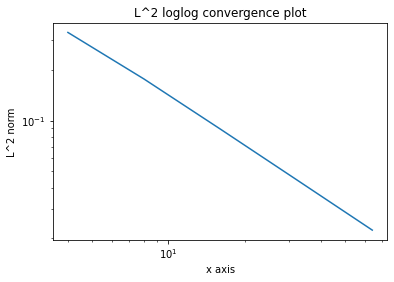

In [24]:
N = []
L2 = []
H1 = []

counter = 0
for n in [4,8,16,32,64]:
    A = A_matrix(n)
    M = M_matrix(n)
    b = b_vector(n)
    v = M.dot(b)
    u = solve_system(A,v,n)
    u = add_boundary_values(u,n)
    N.append(n)
    L2.append(error_computation(n,u)[0])
    H1.append(error_computation(n,u)[1])
    counter+=1
    

plt.title("L^2 loglog convergence plot")
plt.xlabel("x axis")
plt.ylabel("L^2 norm")
plt.loglog(N,L2)



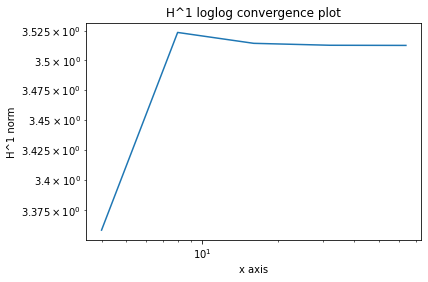

In [25]:
# This shows that the H^{1} norm code has a bug!!

plt.title("H^1 loglog convergence plot")
plt.xlabel("x axis")
plt.ylabel("H^1 norm")
plt.loglog(N,H1)